In [1]:
%autosave 60

Autosaving every 60 seconds


In [81]:
import pandas as pd
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='white')
%matplotlib inline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import decomposition
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

r_state = 11

In [3]:
import warnings
warnings.simplefilter('ignore')

# будем отображать графики прямо в jupyter'e
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 

#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5
import pandas as pd

In [4]:
data_path = '/home/ilyua/ml/data/datasets/mlg-ulb/creditcardfraud/creditcard.csv'

In [5]:
df = pd.read_csv(data_path)

In [6]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


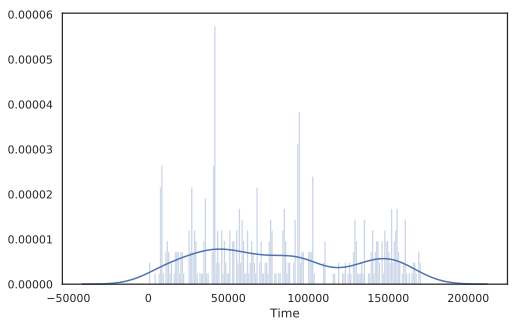

In [8]:
sns.distplot(df[df['Class']==1]['Time'],200);

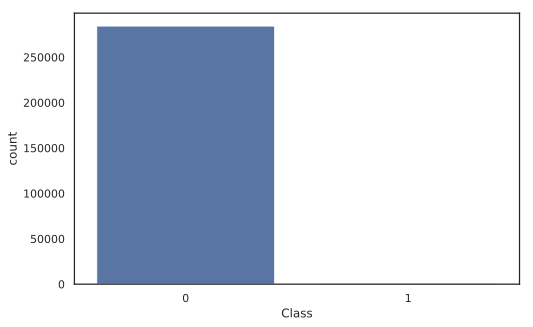

In [72]:
sns.countplot(df['Class']);

In [73]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [74]:
r_df = df.sample(n=10000,random_state = r_state)

In [75]:
X_old = r_df.drop(['Class','Time'], axis=1)
Y_old = r_df['Class']

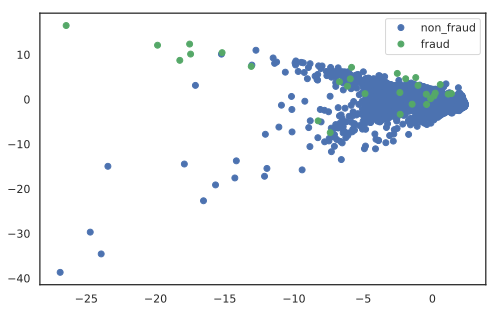

In [76]:
plt.plot(X_old[['V1','V2']].values[Y_old == 0,0], X_old[['V1','V2']].values[Y_old == 0, 1], 'bo', label='non_fraud')
plt.plot(X_old[['V1','V2']].values[Y_old == 1,0], X_old[['V1','V2']].values[Y_old == 1, 1], 'go', label='fraud')
plt.legend(loc=0);

In [77]:
def all_metrics_validation(model,X,Y):
    print("Accuracy score: "+ str(accuracy_score(model.predict(X),Y)))
    print("ROC AUC score: "+ str(roc_auc_score(model.predict(X),Y)))

In [78]:
def create_new_data(data):
    fraud = data[(data['Class']==1)]
    not_fraud = data[(data['Class']==0)]
    new_df=pd.concat([fraud,data])
    for i in range(20):
        new_df=pd.concat([fraud,new_df])       
    X = new_df.drop(['Class'], axis=1)
    Y = new_df['Class']
    return X,Y

In [82]:
X,Y = create_new_data(df)

In [83]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
%%time
tsne = TSNE(random_state=17)
tsne_representation = tsne.fit_transform(X_scaled)

In [ ]:
plt.scatter(tsne_representation[:, 0], tsne_representation[:, 1]);

In [16]:
Y.value_counts()

0    284315
1     10824
Name: Class, dtype: int64

In [17]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, Y, test_size=0.3)

In [18]:
%%time
parameters = {'max_features': ['auto'], 'min_samples_leaf': [1, 3, 5, 7],'max_depth': [1,2,3,5,10],'n_estimators':[10]}
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
rfc = RandomForestClassifier()
gcv = GridSearchCV(rfc, parameters, n_jobs=-1, cv=skf, verbose=1)
gcv.fit(X_train, y_train)


Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   46.2s finished


CPU times: user 19 s, sys: 137 ms, total: 19.1 s
Wall time: 1min


In [19]:
gcv.best_params_ , gcv.best_score_

({'max_depth': 10,
  'max_features': 'auto',
  'min_samples_leaf': 3,
  'n_estimators': 10},
 0.9952951882166731)

In [20]:
model = gcv.best_estimator_

In [21]:
all_metrics_validation(model,X_train, y_train)

Accuracy score: 0.9955275246010349
ROC AUC score: 0.996261352132614


In [22]:
all_metrics_validation(model,X_old, Y_old)

ValueError: Number of features of the model must match the input. Model n_features is 30 and input n_features is 29 

In [ ]:
all_metrics_validation(model,df.drop(['Class'], axis=1), df['Class'])